In [12]:
import BioSimSpace as bss
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import matplotlib
import BioSimSpace._Exceptions 
import sklearn.metrics


In [13]:
_K_B = scipy.constants.Boltzmann
_TEMPERATURE = 300
_N_A = scipy.constants.Avogadro


def inhibition_to_ddg(ki_a: float, ki_b: float) -> float:
    """
    convert experimental Ki values to binding free-energy difference
    :param ki_a: experimental Ki of ligand 1
    :param ki_b: experimental Ki of ligand 1
    :return: experimental RBFE value
    """
    ic50_a = 2 * ki_a
    ic50_b = 2 * ki_b

    return (_K_B * _N_A * _TEMPERATURE / 4184) * np.log(ic50_b / ic50_a)


def get_experimental_error(error_a, ki_a, error_b, ki_b):
    fraction = ki_b / ki_a
    fraction_error = fraction * np.sqrt((error_b / ki_b) ** 2 + (error_a / ki_a) ** 2)
    return (_K_B * _TEMPERATURE * fraction_error / fraction) * _N_A / 4184


def bootstrap(experimental: np.array, calculated: np.array, n_samples = 10000, alpha_level = 0.05):
    """
    bootstrap correlation statistics and MUE
    """
    n_data_samples = len(experimental)
    statistics_dict = {"r": [],
                       "mue": [],
                       "spearman": []}

    for i in range(n_samples):
        if i==0:
            experimental_samples = experimental
            calculated_samples = calculated
        else:
            bootstrap_sample = np.random.choice(range(n_data_samples), size = n_samples)
            experimental_samples = [experimental[i] for i in bootstrap_sample]
            calculated_samples = [calculated[i] for i in bootstrap_sample]
        pearson, _ = scipy.stats.pearsonr(experimental_samples, calculated_samples)
        mue = sklearn.metrics.mean_absolute_error(experimental_samples, calculated_samples)
        spearman, _ = scipy.stats.spearmanr(experimental_samples, calculated_samples)
        statistics_dict["r"].append(pearson)
        statistics_dict["mue"].append(mue)
        statistics_dict["spearman"].append(spearman)
    
    results = {"r": {},
               "mue": {},
               "spearman": {}}
    lower_fraction = alpha_level/2.0
    upper_fraction = 1 - lower_fraction
    for statistic in statistics_dict.keys():
        results[statistic]["real"] = statistics_dict[statistic][0]
        statistics_dict[statistic] = sorted(statistics_dict[statistic])
        results[statistic]["mean"] = np.mean(statistics_dict[statistic])
        results[statistic]["lower"] = statistics_dict[statistic][int(n_samples * lower_fraction)]
        results[statistic]["upper"] = statistics_dict[statistic][int(n_samples * upper_fraction)]
    return results




In [14]:
header_file = "/home/jguven/projects/metalloenzymes/scripts/simfile_header.txt"
with open(header_file, "r") as file:
    header = file.readlines()

somd_path = "/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/"
paths = glob.glob(somd_path + "*/")
# paths = [somd_path + "lig_1~lig_4/", 
#         # somd_path + "lig_1~lig_5/"
#          ]
for path in paths:
    ligand = path.split("/")[-2]
    print(ligand)
    free_directory = somd_path + ligand + "/unbound/"
    bound_directory = somd_path + ligand + "/bound/"
    
    unbound_min_simfiles = sorted(glob.glob(free_directory + "/minimisation/lambda_*/simfile.dat"))

    unbound_simfiles = sorted(glob.glob(free_directory + "lambda_*/simfile.dat"))

    bound_simfiles = sorted(glob.glob(bound_directory + "lambda_*/simfile.dat"))

    for i in range(len(unbound_min_simfiles)):

        with open(unbound_min_simfiles[i], "r") as file:
            min_simfile_lines = file.readlines()

        with open(unbound_min_simfiles[i], "r") as file:
            for j, line in enumerate(file):
                if "lambda" in line:
                    start = j
                if "#" not in line:
                    end = j
                    break

        lambda_header = min_simfile_lines[start:end]
        full_header = header + lambda_header

        with open(unbound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)

        with open(bound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)

lig_11~lig_5
lig_1~lig_4
lig_16~lig_9
lig_6~lig_9
lig_7~lig_9
lig_13~lig_16
lig_11~lig_14
lig_2~lig_4
lig_10~lig_6
lig_6~lig_8
lig_15~lig_3
lig_12~lig_15
lig_11~lig_12
lig_1~lig_5
lig_2~lig_9
lig_14~lig_15
lig_4~lig_9
lig_11~lig_3
lig_11~lig_4
lig_6~lig_7
lig_10~lig_8
lig_13~lig_6


In [15]:
analysis_file = "../kpc2/afe/somd_results_analysis_remove_big.txt"

# somd_path = "/home/jguven/projects/metalloenzymes/starmap/outputs/with_min/SOMD/"
# paths = sorted(glob.glob(somd_path + "*/"))

for path in paths:
    print(path)
with open(analysis_file, "w") as file:
    for path in paths:
        ligand = path.split("/")[-2]
        free_directory = somd_path + ligand + "/unbound/"
        bound_directory = somd_path + ligand + "/bound/"

        print(ligand)
        transformation = path.split("/")[-2]
        file.write(transformation+"\n")
        free_directory = path + "unbound/"
        bound_directory = path + "bound/"
        try:
            pmf_free, overlap_matrix_free = bss.FreeEnergy.Relative.analyse(free_directory)
            pmf_bound, overlap_matrix_bound = bss.FreeEnergy.Relative.analyse(bound_directory)    
            free_energy_difference, free_energy_error = bss.FreeEnergy.Relative.difference(pmf_bound, pmf_free)
            file.write(f"{free_energy_difference} \u00B1 {free_energy_error} \n")    
        except IndexError as e:
            print(str(e)+"\n")
        except ValueError as e:
            print(str(e)+"\n")
        except BioSimSpace._Exceptions.AnalysisError as e:
            print(str(e))

/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_11~lig_5/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_1~lig_4/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_16~lig_9/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_6~lig_9/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_7~lig_9/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_13~lig_16/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_11~lig_14/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_2~lig_4/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_10~lig_6/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_6~lig_8/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_15~lig_3/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_12~lig_15/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_11~lig_12/
/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_1~lig_5/
/home/jguven/projects/metalloenzymes

In [16]:
with open(analysis_file, "r") as file:
    lines = file.readlines()
results = [line for line in lines[1:len(lines):2]]
free_energy_differences = []
free_energy_errors = []
for result in results:
    split_results = result.split("±")
    free_energy_differences.append(float(split_results[0].replace("kcal/mol", "").replace("⁻¹ \n", "")))
    free_energy_errors.append(float(split_results[1].replace("kcal/mol", "").replace("⁻¹ \n", "").replace("kcal mol", "")))
perturbations = [line.strip() for line in lines[0:len(lines):2]]    
print(perturbations)

['lig_1~lig_4', 'lig_16~lig_9', 'lig_6~lig_9', 'lig_7~lig_9', 'lig_13~lig_16', 'lig_2~lig_4', 'lig_10~lig_6', 'lig_6~lig_8', 'lig_15~lig_3', 'lig_12~lig_15', 'lig_1~lig_5', 'lig_2~lig_9', 'lig_14~lig_15', 'lig_4~lig_9', 'lig_6~lig_7', 'lig_10~lig_8', 'lig_13~lig_6']


In [17]:
first_indices = []
second_indices = []
for line in perturbations:
    no_newline = line.strip("\n")
    lig_1 = no_newline.split("~")[0].replace("lig_", "")
    lig_2 = no_newline.split("~")[1].replace("lig_", "")  
    first_indices.append(int(lig_1) - 1)
    second_indices.append(int(lig_2) - 1)

for i in range(len(first_indices)):
    print(first_indices[i], second_indices[i])

0 3
15 8
5 8
6 8
12 15
1 3
9 5
5 7
14 2
11 14
0 4
1 8
13 14
3 8
5 6
9 7
12 5


In [18]:
experimental_file = pd.read_csv("../kpc2/afe/experimental_ki.txt")
experimental_ki, experimental_ki_error = experimental_file["K_i"], experimental_file["K_i_err"]
ligand_1 = experimental_ki[0]
ligand_1_error = experimental_ki_error[0]
experimental_free_energies = []
experimental_errors = []
# for i in range(1, len(experimental_ki)):
#     ddg = inhibition_to_ddg(ligand_1, experimental_ki[i])
#     error = get_experimental_error(ligand_1_error, ligand_1, experimental_ki_error[i], experimental_ki[i])
#     experimental_free_energies.append(ddg)
#     experimental_errors.append(error)
# # print(experimental_file)

experimental_free_energies = []
experimental_errors = []
for i in range(len(first_indices)):
    i_1, i_2 = first_indices[i], second_indices[i]
    experimental_free_energy = inhibition_to_ddg(experimental_ki[i_1], experimental_ki[i_2])
    # error_a, ki_a, error_b, ki_b
    experimental_error = get_experimental_error(experimental_ki_error[i_1], experimental_ki[i_1], experimental_ki_error[i_2], experimental_ki[i_2])
    experimental_free_energies.append(experimental_free_energy)
    experimental_errors.append(experimental_error)
    print(i_1, i_2)

0 3
15 8
5 8
6 8
12 15
1 3
9 5
5 7
14 2
11 14
0 4
1 8
13 14
3 8
5 6
9 7
12 5


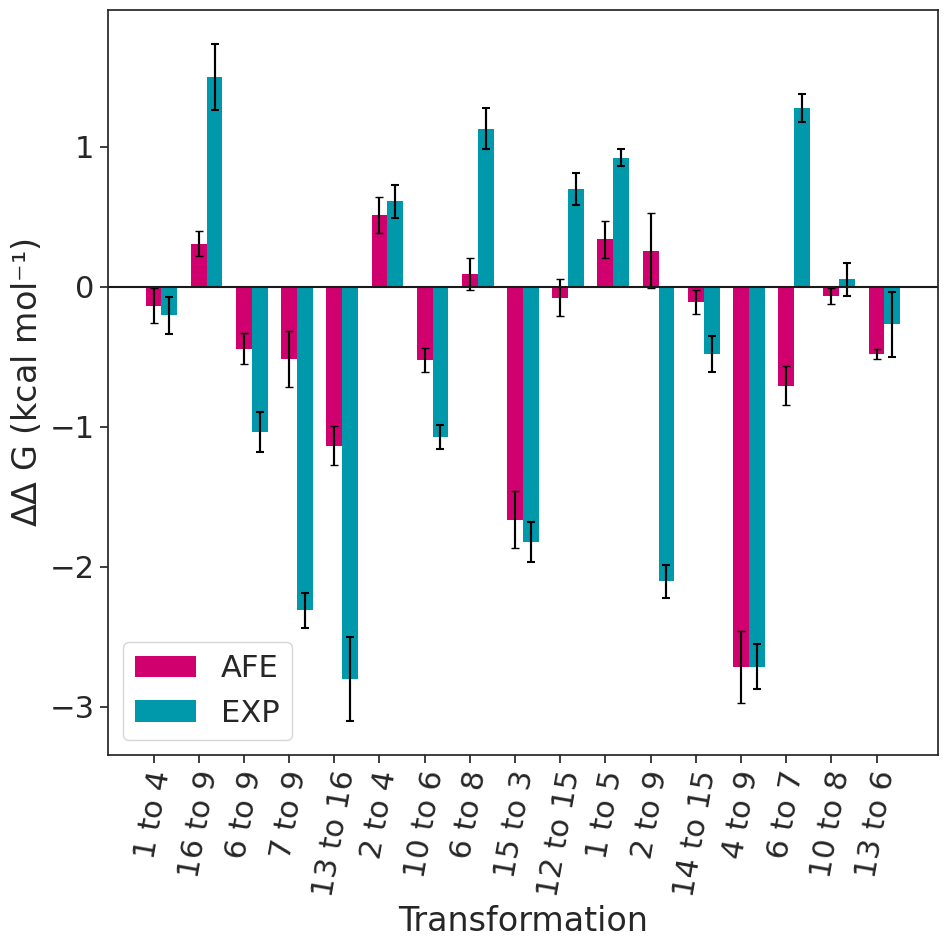

In [22]:
fig = plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
x_label_locations = np.arange(len(free_energy_differences))
bar_width = 0.35

plt.bar(x_label_locations - bar_width / 2,
        height=free_energy_differences,
        width=bar_width,
        yerr=free_energy_errors,
        label="AFE",
        color="#D0006F",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations - bar_width / 2,
                            free_energy_differences,
                            color="black",
                            yerr=free_energy_errors,
                            capsize=3,
                            linestyle="")

plt.bar(x_label_locations + bar_width / 2,
        height=experimental_free_energies,
        width=bar_width,
        yerr=experimental_errors,
        label="EXP",
        color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations + bar_width / 2,
                            experimental_free_energies,
                            color="black",
                            yerr=experimental_errors,
                            capsize=3,
                            linestyle="")

for cap in caps:
    cap.set_color("black")
    cap.set_markeredgewidth(1.5)
# plt.ylim(-55, -40)

labels = ["1 to 4",
          "16 to 9",
          "6 to 9",
          "7 to 9",
          "13 to 16",
          "2 to 4",
          "10 to 6",
          "6 to 8",
          "15 to 3",
          "12 to 15",
          "1 to 5", 
          "2 to 9",
          "14 to 15",
          "4 to 9",
          "6 to 7",
          "10 to 8",
          "13 to 6"]
plt.axhline(0, 0, 1, c="k")
# plt.ylim(-6, 6)
plt.xlabel("Transformation")
plt.xticks(x_label_locations - bar_width / 2, labels, rotation=80, ha="center")
plt.legend()
plt.ylabel("$\Delta \Delta$ G (kcal mol⁻¹)")
plt.tight_layout()
plt.savefig("ddg.png", transparent=True, dpi=1200)

In [12]:
stats = bootstrap(experimental_free_energies, free_energy_differences)
print(stats)

{'r': {'real': 0.24267670703988936, 'mean': 0.24260026500168824, 'lower': 0.23251369336961647, 'upper': 0.252581133746772}, 'mue': {'real': 3.6376399073208634, 'mean': 3.6376551121109113, 'lower': 3.5165489529776415, 'upper': 3.756627917435375}, 'spearman': {'real': 0.5923207227555054, 'mean': 0.5922973672272428, 'lower': 0.5791213152789054, 'upper': 0.6053653376309234}}


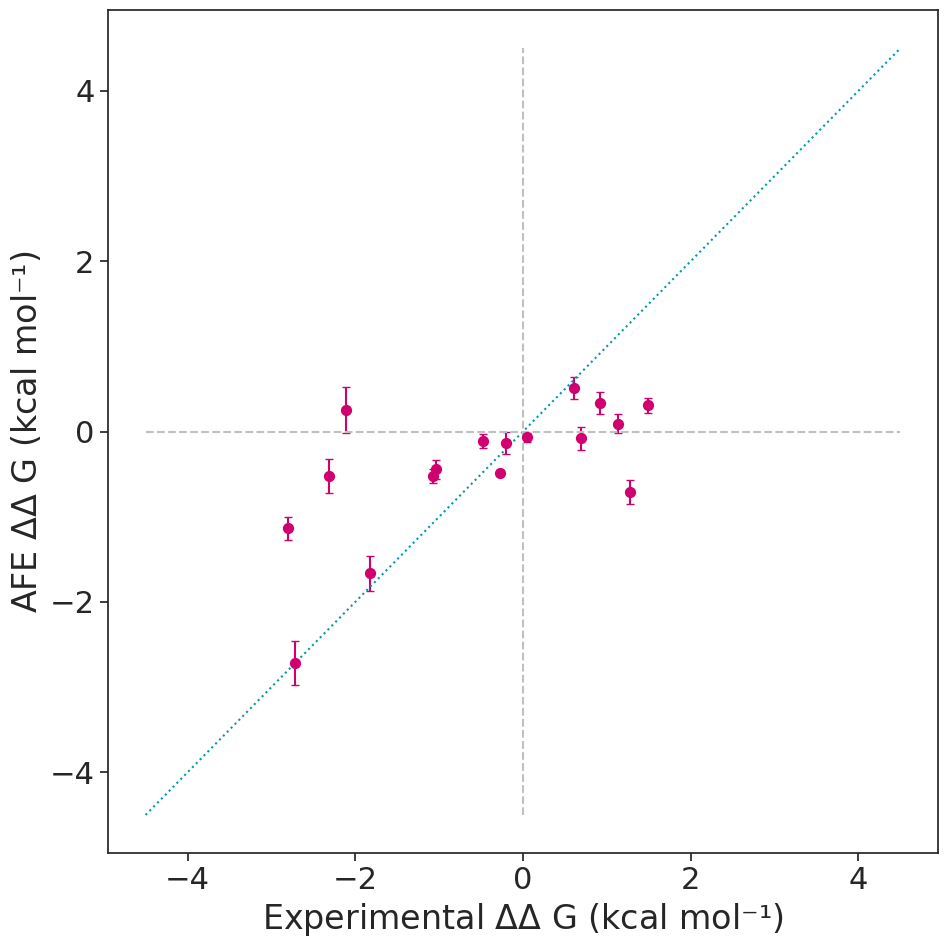

In [25]:
plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
plt.scatter(experimental_free_energies, free_energy_differences, s=50, color="#D0006F")
# plt.scatter(3, 2.5, s=0)

(_, caps, _) = plt.errorbar(experimental_free_energies,
                           free_energy_differences,
                           color="#D0006F",
                           yerr=free_energy_errors,
                           capsize=3,
                           linestyle="",
                           zorder=-1)

plt.plot([-4.5, 4.5], [-4.5, 4.5], color="#0099AB", linestyle=":", zorder=-1)
plt.vlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
plt.hlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
# plt.xlim(-4.5, 4.5)
# plt.ylim(-4.5, 4.5)
plt.xlabel("Experimental $\Delta \Delta$ G (kcal mol⁻¹)")
# plt.xticks(x_label_locations - bar_width / 2, labels, rotation=80, ha="center")

plt.ylabel("AFE $\Delta \Delta$ G (kcal mol⁻¹)")
plt.tight_layout()
plt.savefig("corr.png", transparent=True, dpi=1200)

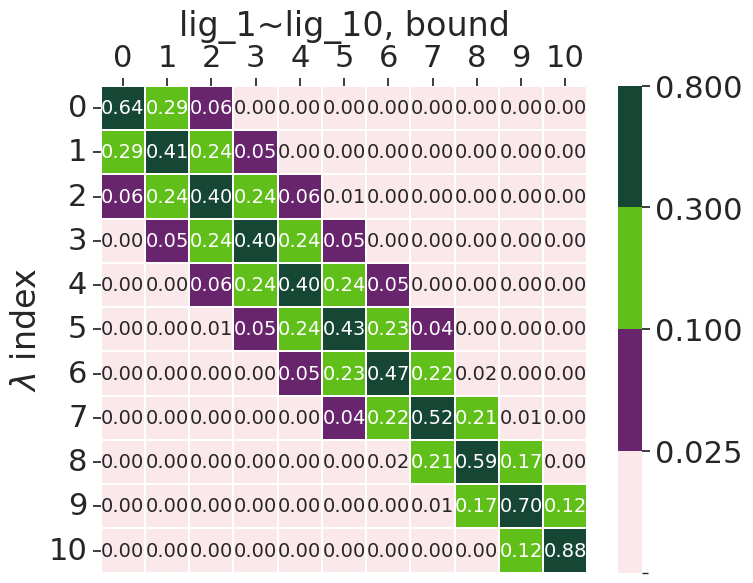

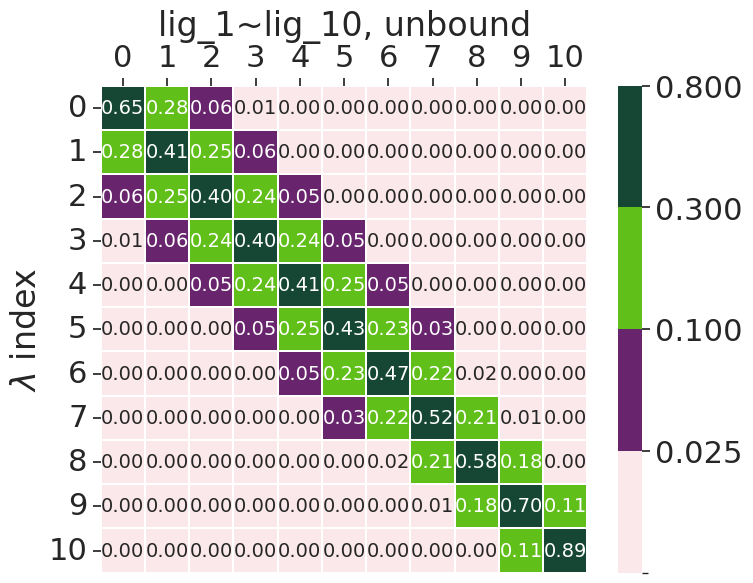

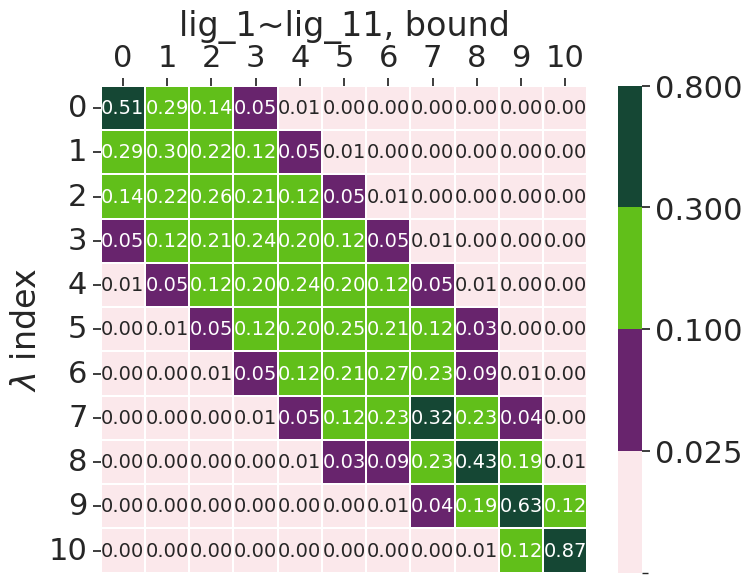

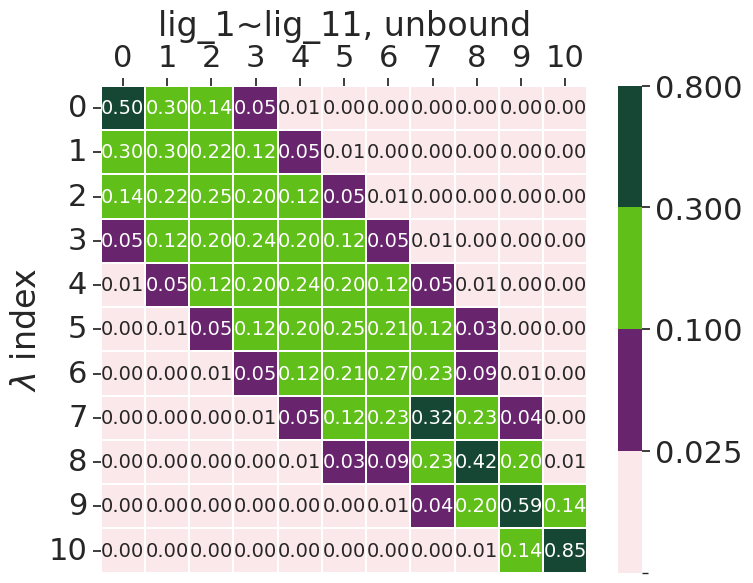

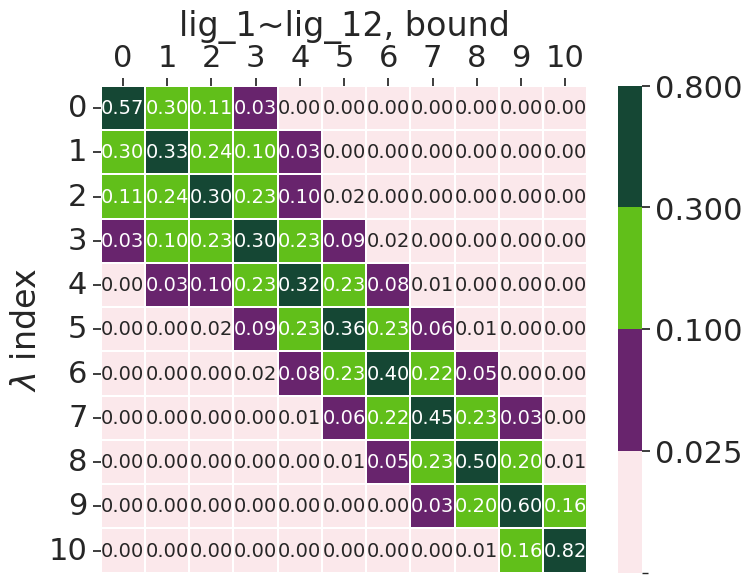

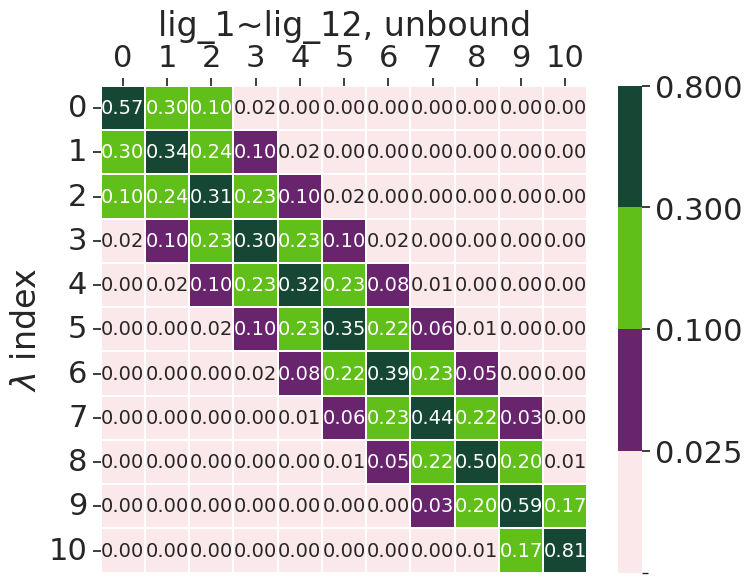

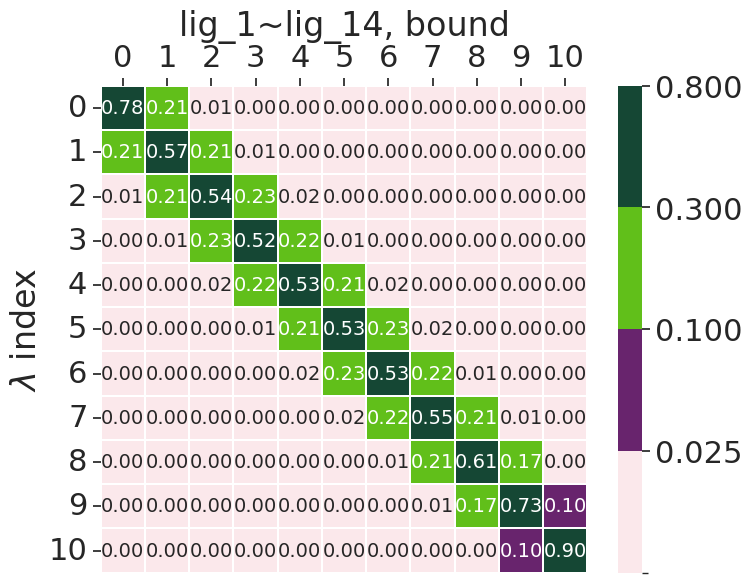

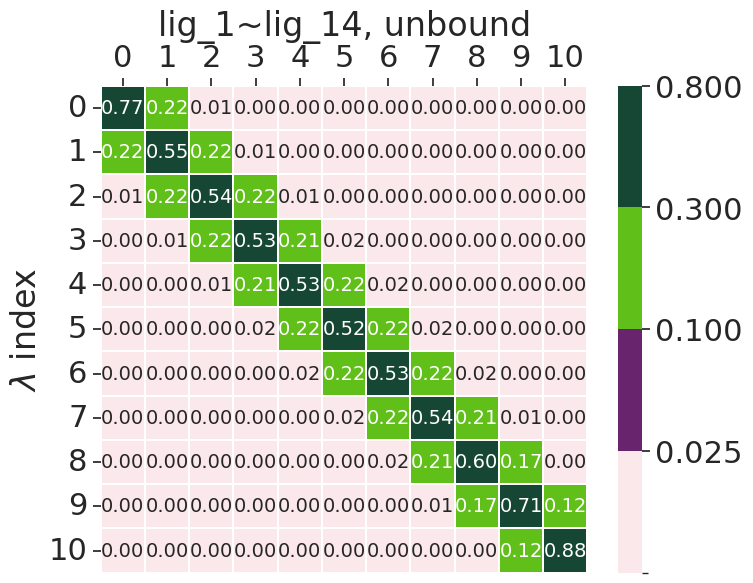

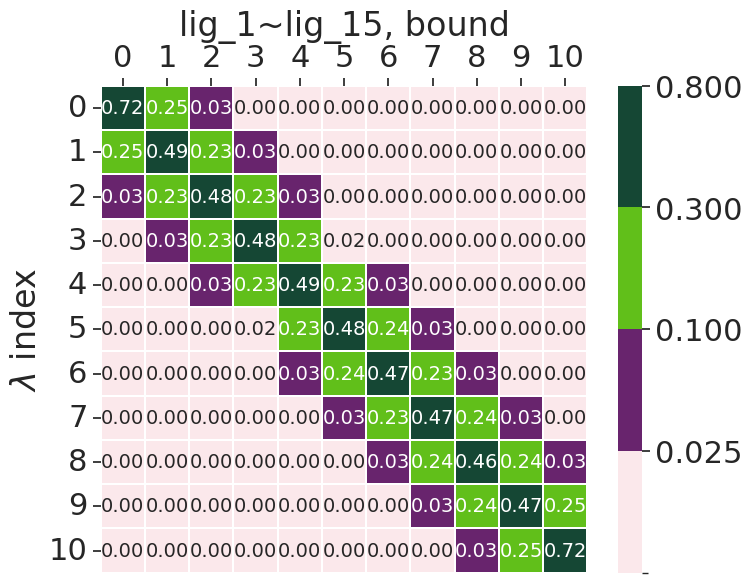

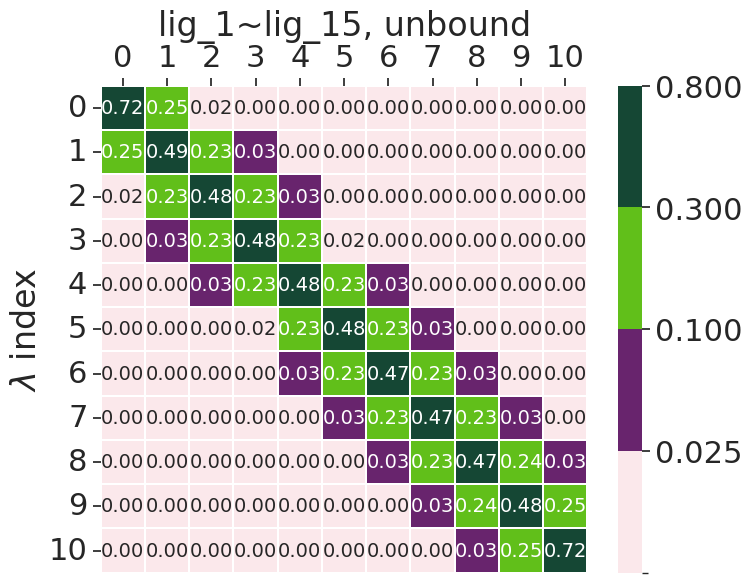

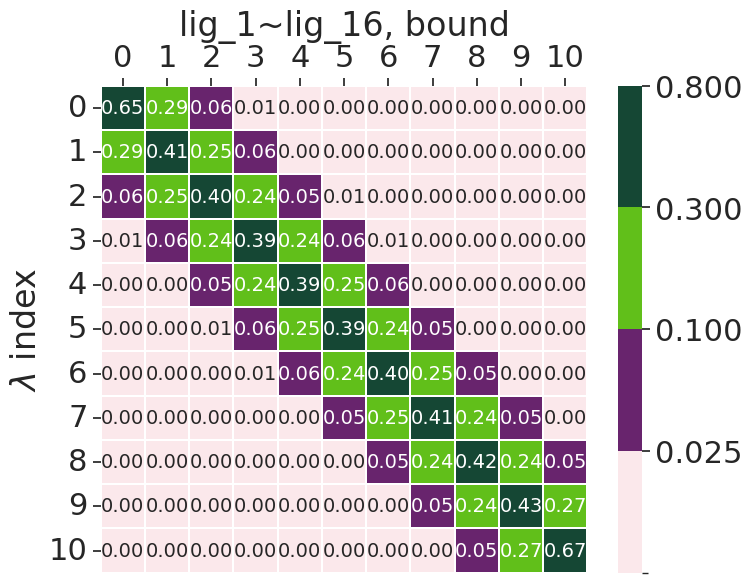

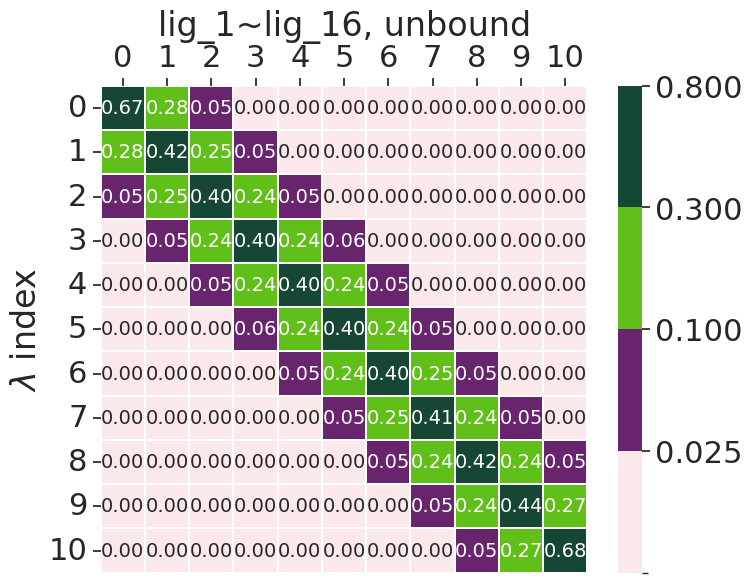

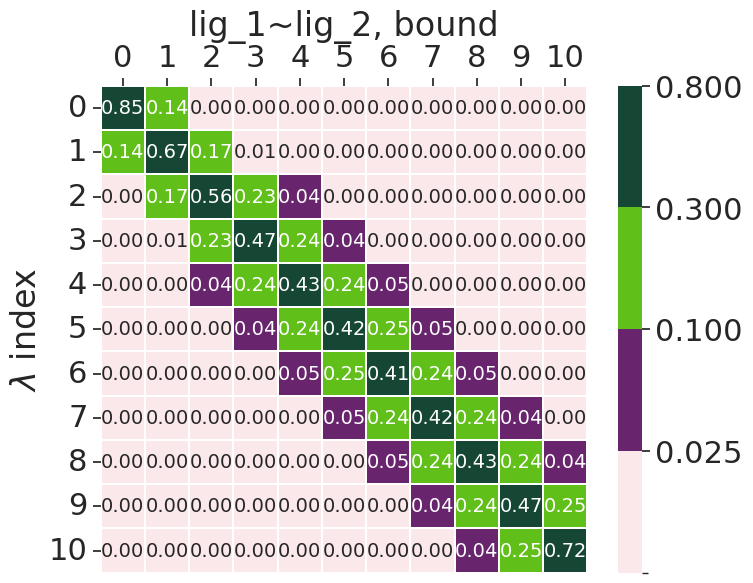

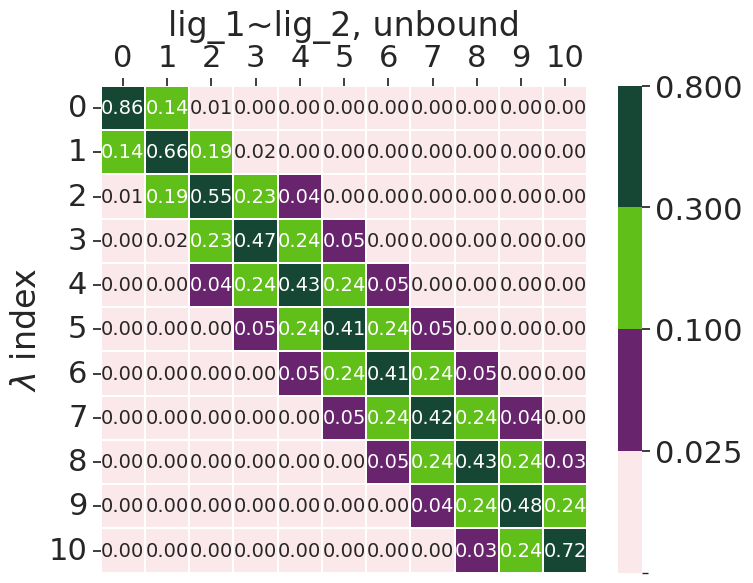

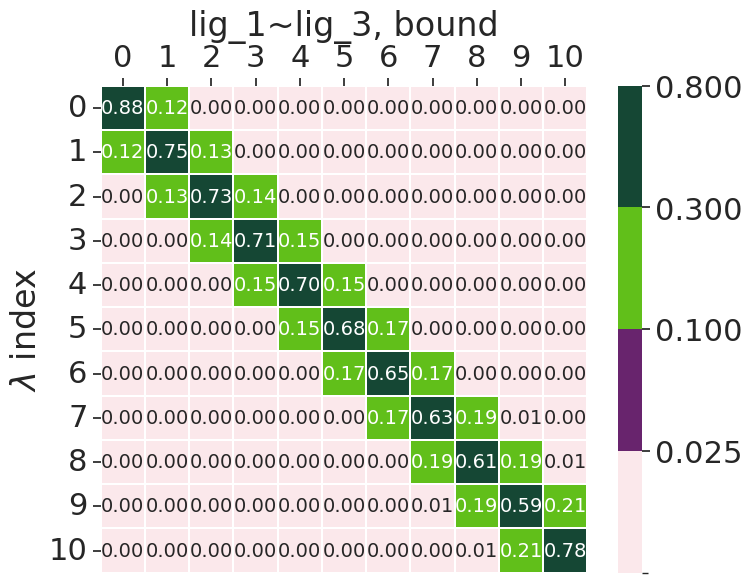

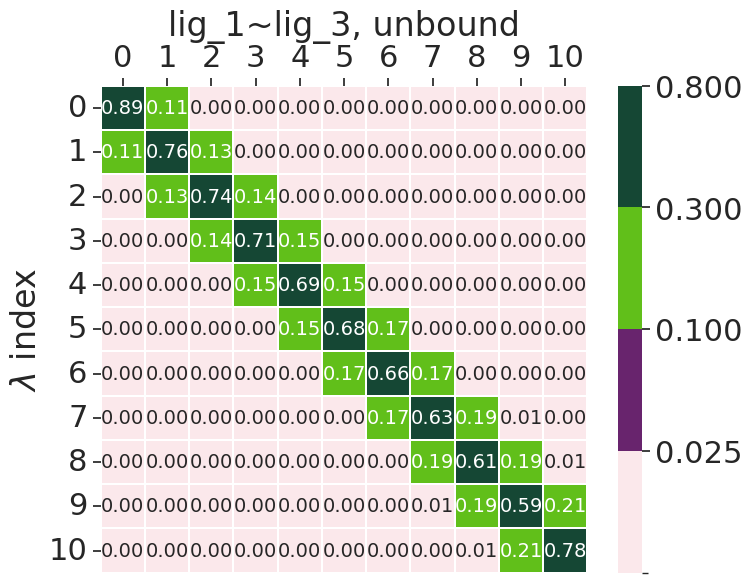

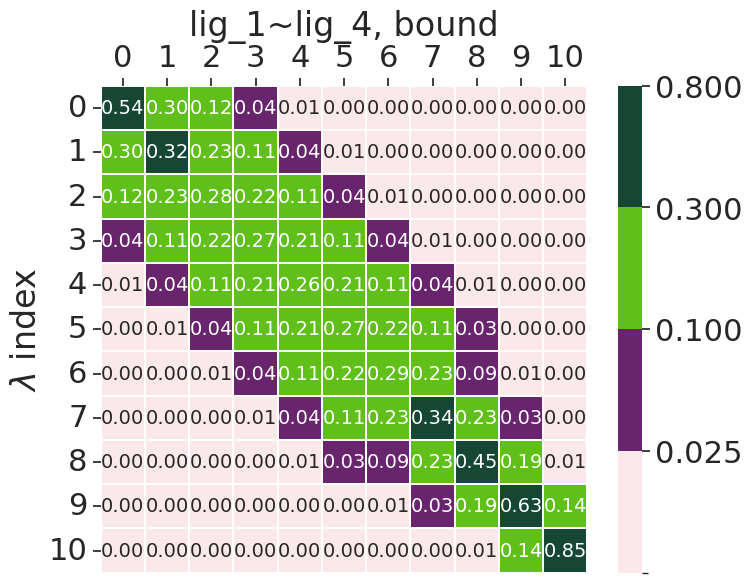

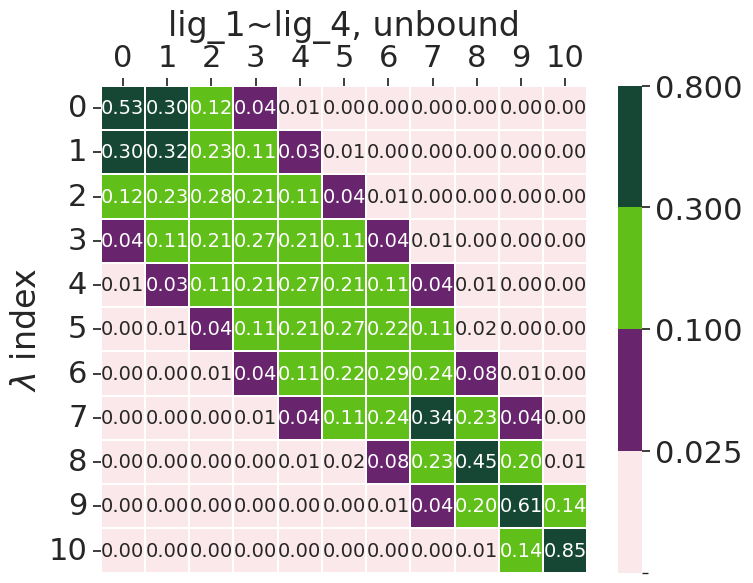

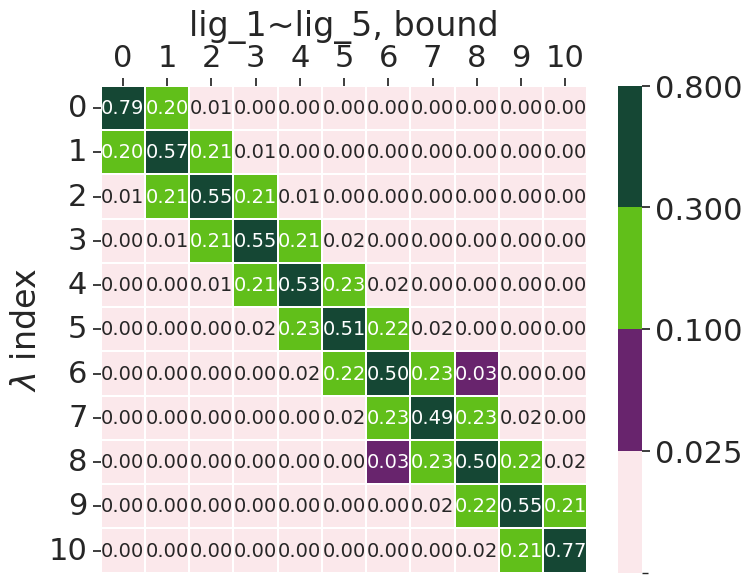

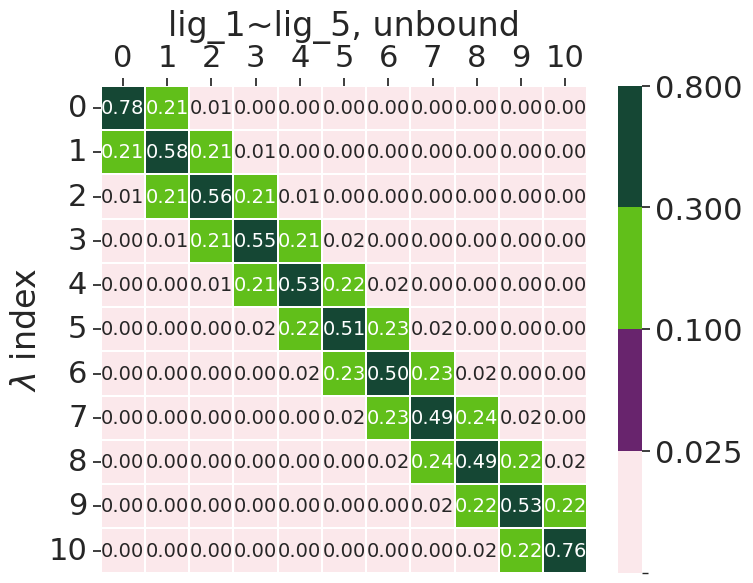

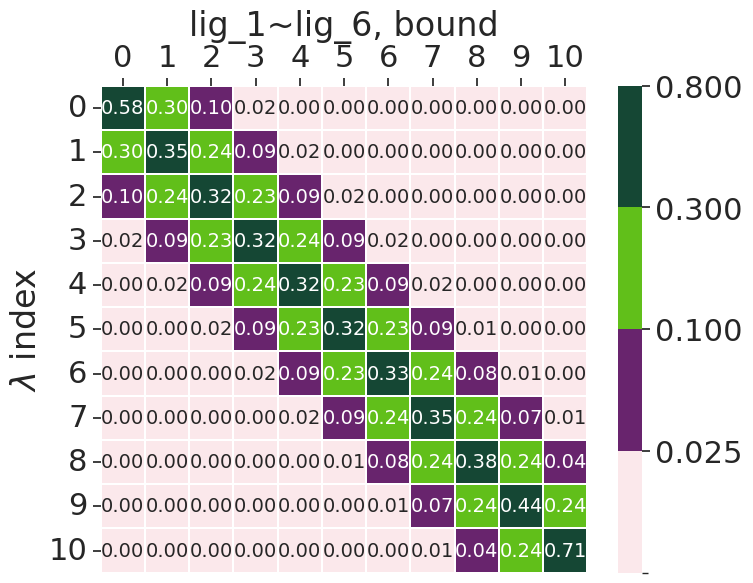

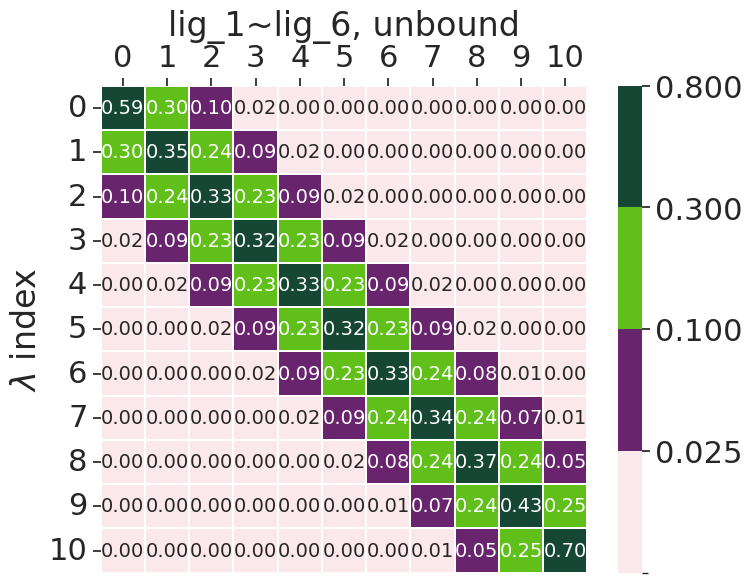

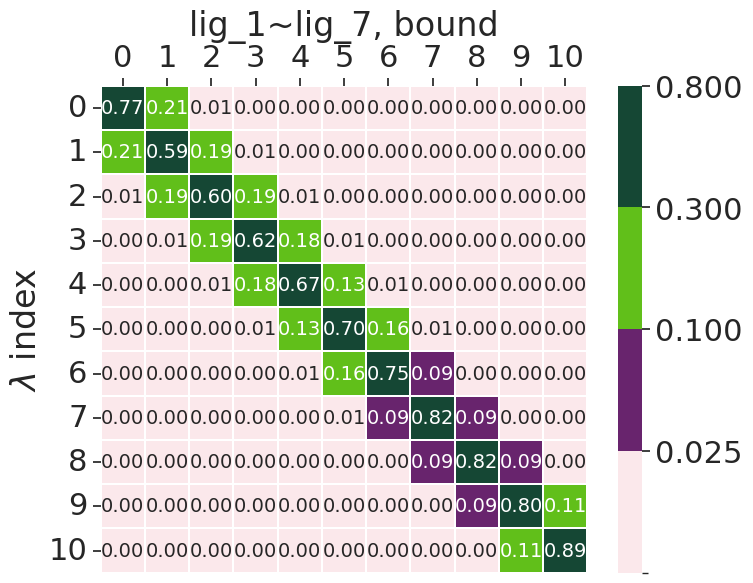

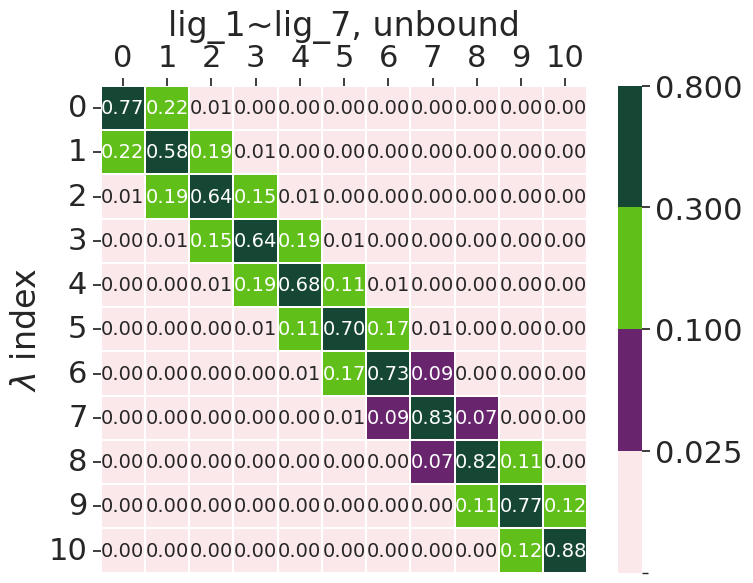

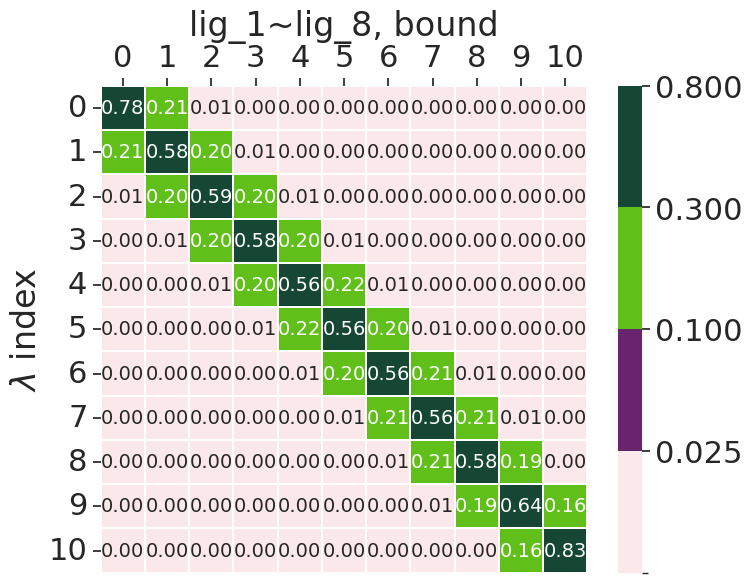

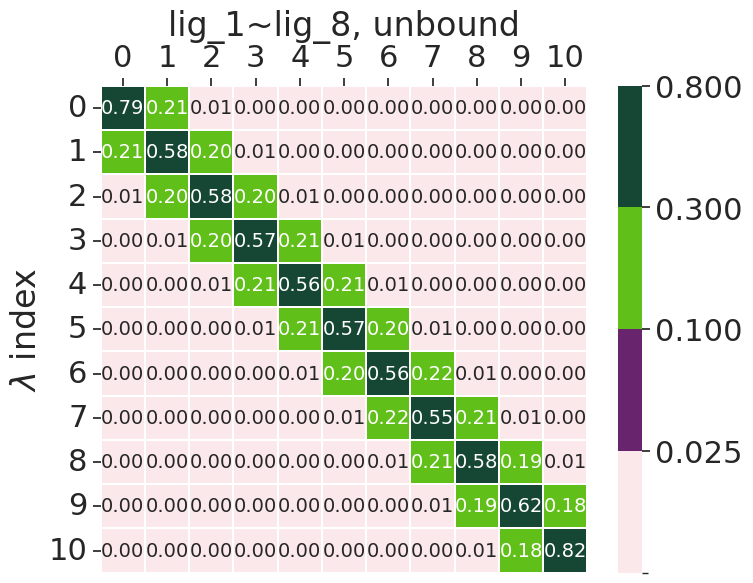

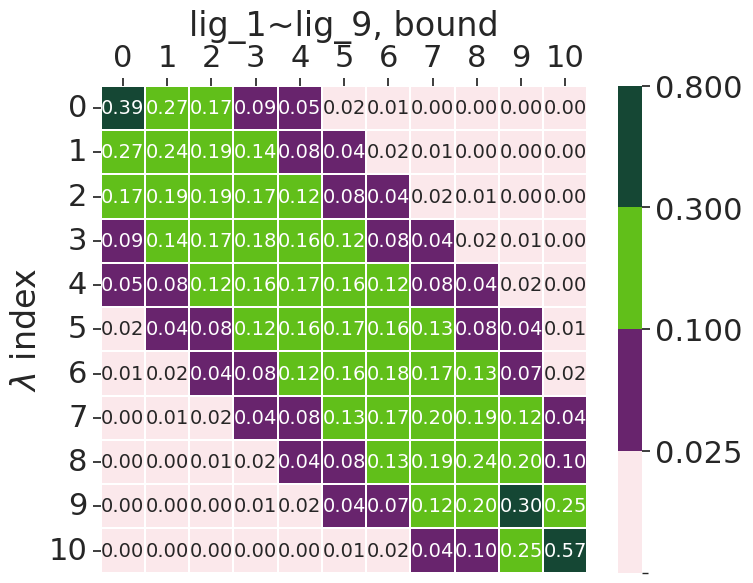

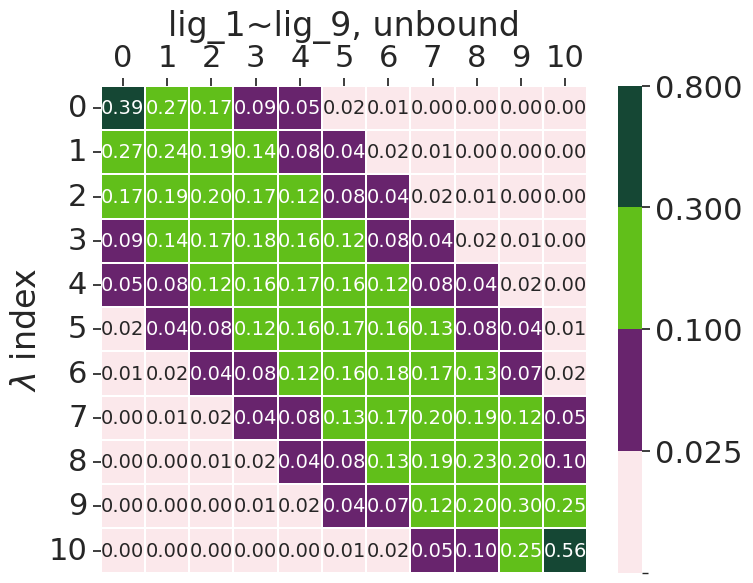

In [14]:
stages = ["bound", "unbound"]
for perturbation in perturbations:

    for stage in stages:

        mbar_file = f"../starmap/outputs/with_min/SOMD/{perturbation}/{stage}/mbar.txt"
        start_index = 1
        end_index = -1
        matrix_lines = []
        with open(mbar_file) as file:
            lines = file.readlines()
            for i in range(len(lines)):
                if "#Overlap matrix" in lines[i]:
                    start_index = i + 1
                elif "#DG from neighbouring lambda in kcal/mol" in lines[i]:
                    end_index = i
            matrix_lines = lines[start_index:end_index]
        
        matrix = []
        for line in matrix_lines:
            split_line = line.replace("\n", "").split(" ")
            new_line = [float(x) for x in split_line]
            matrix.append(new_line)
        
        colour_map = matplotlib.colors.ListedColormap(['#FBE8EB','#68246D','#61BF1A', '#154734'])
        n_colours = colour_map.N
        boundary_values = [0.0, 0.025, 0.1, 0.3, 0.8]
        norm_colours = matplotlib.colors.BoundaryNorm(boundary_values, n_colours, clip=False)
        colour_bar_args = dict(ticks=[0.025, 0.1, 0.3, 0.8],
                            shrink=0.685)

        fig = plt.figure(figsize=(8, 8))
        sns.set_style("ticks")
        sns.set_context("notebook", font_scale=2)
        ax = sns.heatmap(matrix, 
                        annot=True, 
                        fmt=".2f", 
                        linewidths=0.3, 
                        annot_kws={"size": 14}, 
                        square=True, 
                        robust=True, 
                        cmap=colour_map,
                        norm=norm_colours, 
                        cbar_kws=colour_bar_args,
                        vmax=1
                        )
        ax.xaxis.tick_top()
        ax.tick_params(axis="y", rotation=360)
        ax.set_title(f"{perturbation}, {stage}", fontsize=24)
        ax.set_ylabel(r"$\lambda$ index", fontsize=24)
        # ax.set_xlabel(f"{stage} ligand {ligand}", fontsize=24)
        fig.tight_layout()

In [103]:
# free_directory = "/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_1~lig_2/unbound/"
# bound_directory = "/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_1~lig_2/bound/"



header_file = "/home/jguven/projects/metalloenzymes/scripts/simfile_header.txt"
with open(header_file, "r") as file:
    header = file.readlines()

somd_path = "/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/"
paths = glob.glob(somd_path + "*/")

for path in paths:
    ligand = path.split("/")[-2]
    free_directory = somd_path + ligand + "/unbound/"
    bound_directory = somd_path + ligand + "/bound/"
    
    unbound_min_simfiles = sorted(glob.glob(free_directory + "/minimisation/lambda_*/simfile.dat"))

    unbound_simfiles = sorted(glob.glob(free_directory + "lambda_*/simfile.dat"))

    bound_simfiles = sorted(glob.glob(bound_directory + "lambda_*/simfile.dat"))

    for i in range(len(unbound_min_simfiles)):

        with open(unbound_min_simfiles[i], "r") as file:
            min_simfile_lines = file.readlines()

        with open(unbound_min_simfiles[i], "r") as file:
            for j, line in enumerate(file):
                if "lambda" in line:
                    start = j
                if "#" not in line:
                    end = j
                    break

        lambda_header = min_simfile_lines[start:end]
        full_header = header + lambda_header

        with open(unbound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)

        with open(bound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)


# for simfile in unbound_simfiles:

# for simfile in bound_simfiles:
#     with open(simfile, "r+") as file:
#         data = file.readlines()
#         file.seek(0, 0)
#         header_and_data = header + data
#         file.writelines(header_and_data)



In [42]:

# unbound_simfiles = glob.glob(free_directory + "lambda_*/simfile.dat")
# bound_simfiles = glob.glob(bound_directory + "lambda_*/simfile.dat")

# for simfile in unbound_simfiles:
#     with open(simfile, "r+") as file:
#         data = file.readlines()
#         file.seek(0, 0)
#         header_and_data = header + data
#         file.writelines(header_and_data)

# for simfile in bound_simfiles:
#     with open(simfile, "r+") as file:
#         data = file.readlines()
#         file.seek(0, 0)
#         header_and_data = header + data
#         file.writelines(header_and_data)



lig_5~lig_10
lig_11~lig_5
lig_1~lig_4
lig_16~lig_9
lig_11~lig_15
lig_13~lig_7
lig_9~lig_5
lig_1~lig_2
lig_3~lig_6
lig_2~lig_4
lig_15~lig_9
lig_15~lig_5
lig_13~lig_3
lig_4~lig_16
lig_6~lig_8
lig_4~lig_6
lig_12~lig_15
lig_10~lig_4
lig_14~lig_15
lig_6~lig_7
lig_10~lig_8
lig_9~lig_10
lig_13~lig_6
lig_16~lig_10
lig_12~lig_14


In [105]:
with open(analysis_file, "r") as file:
    lines = file.readlines()
results = [line for line in lines[1:len(lines):2]]
free_energy_differences = []
free_energy_errors = []
for result in results:
    split_results = result.split("±")
    free_energy_differences.append(float(split_results[0].replace("kcal/mol", "").replace("⁻¹ \n", "")))
    free_energy_errors.append(float(split_results[1].replace("kcal/mol", "").replace("⁻¹ \n", "").replace("kcal mol", "")))
    

In [106]:
perturbations = [line for line in lines[0:len(lines):2]]
for line in perturbations:
    print(line)

lig_5~lig_10

lig_11~lig_5

lig_1~lig_4

lig_16~lig_9

lig_11~lig_15

lig_13~lig_7

lig_9~lig_5

lig_1~lig_2

lig_3~lig_6

lig_2~lig_4

lig_15~lig_9

lig_15~lig_5

lig_13~lig_3

lig_4~lig_16

lig_6~lig_8

lig_4~lig_6

lig_12~lig_15

lig_10~lig_4

lig_14~lig_15

lig_6~lig_7

lig_10~lig_8

lig_9~lig_10

lig_13~lig_6

lig_16~lig_10

lig_12~lig_14



In [107]:
first_indices = []
second_indices = []
for line in perturbations:
    no_newline = line.strip("\n")
    lig_1 = no_newline.split("~")[0].replace("lig_", "")
    lig_2 = no_newline.split("~")[1].replace("lig_", "")  
    first_indices.append(int(lig_1) - 1)
    second_indices.append(int(lig_2) - 1)

for i in range(len(first_indices)):
    print(first_indices[i], second_indices[i])

4 9
10 4
0 3
15 8
10 14
12 6
8 4
0 1
2 5
1 3
14 8
14 4
12 2
3 15
5 7
3 5
11 14
9 3
13 14
5 6
9 7
8 9
12 5
15 9
11 13


In [109]:
# experimental_free_energies = []
# experimental_errors = []
# for i in range(len(first_indices)):
#     i_1, i_2 = first_indices[i], second_indices[i]
#     experimental_free_energy = inhibition_to_ddg(experimental_ki[i_1], experimental_ki[i_2])
#     # error_a, ki_a, error_b, ki_b
#     experimental_error = get_experimental_error(experimental_ki_error[i_1], experimental_ki[i_1], experimental_ki_error[i_2], experimental_ki[i_2])
#     experimental_free_energies.append(experimental_free_energy)
#     experimental_errors.append(experimental_error)
                                                

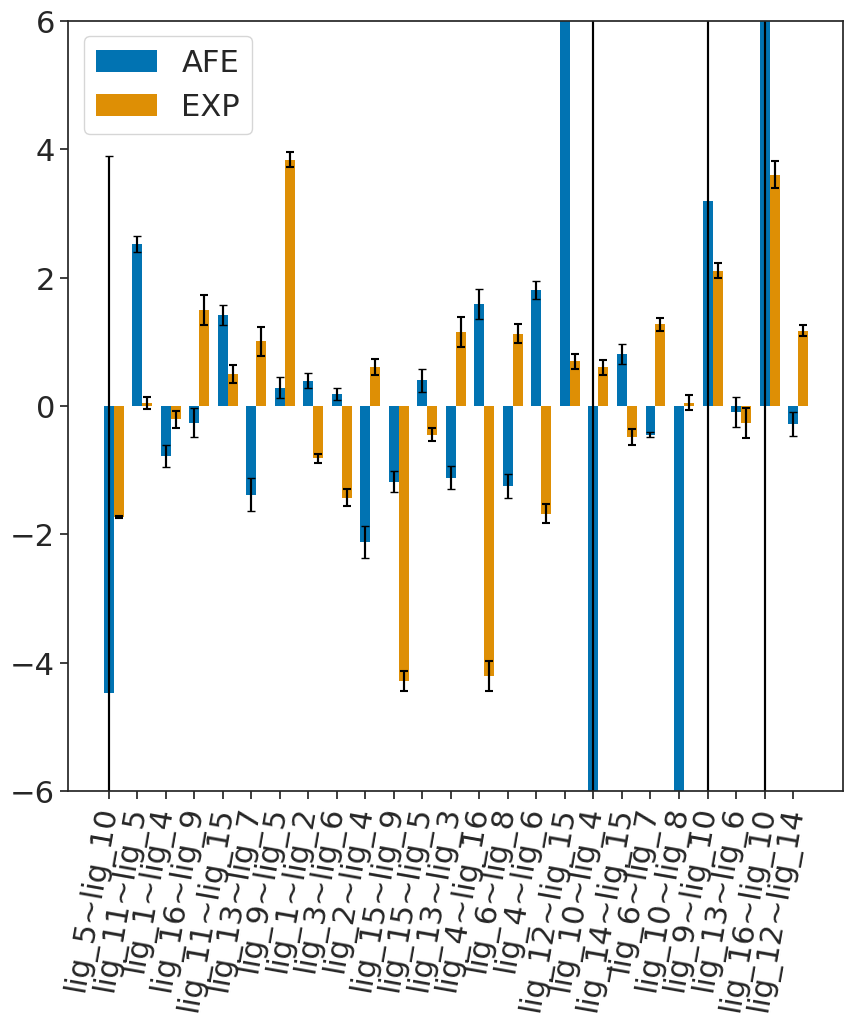

In [111]:
fig = plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
x_label_locations = np.arange(len(free_energy_differences))
bar_width = 0.35

plt.bar(x_label_locations - bar_width / 2,
        height=free_energy_differences,
        width=bar_width,
        yerr=free_energy_errors,
        label="AFE",
        # color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations - bar_width / 2,
                            free_energy_differences,
                            color="black",
                            yerr=free_energy_errors,
                            capsize=3,
                            linestyle="")

plt.bar(x_label_locations + bar_width / 2,
        height=experimental_free_energies,
        width=bar_width,
        yerr=experimental_errors,
        label="EXP",
        # color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations + bar_width / 2,
                            experimental_free_energies,
                            color="black",
                            yerr=experimental_errors,
                            capsize=3,
                            linestyle="")

for cap in caps:
    cap.set_color("black")
    cap.set_markeredgewidth(1.5)
# plt.ylim(-55, -40)
plt.ylim(-6, 6)
plt.xticks(x_label_locations - bar_width / 2, perturbations, rotation=80, ha="center")
plt.legend()


(-4.5, 4.5)

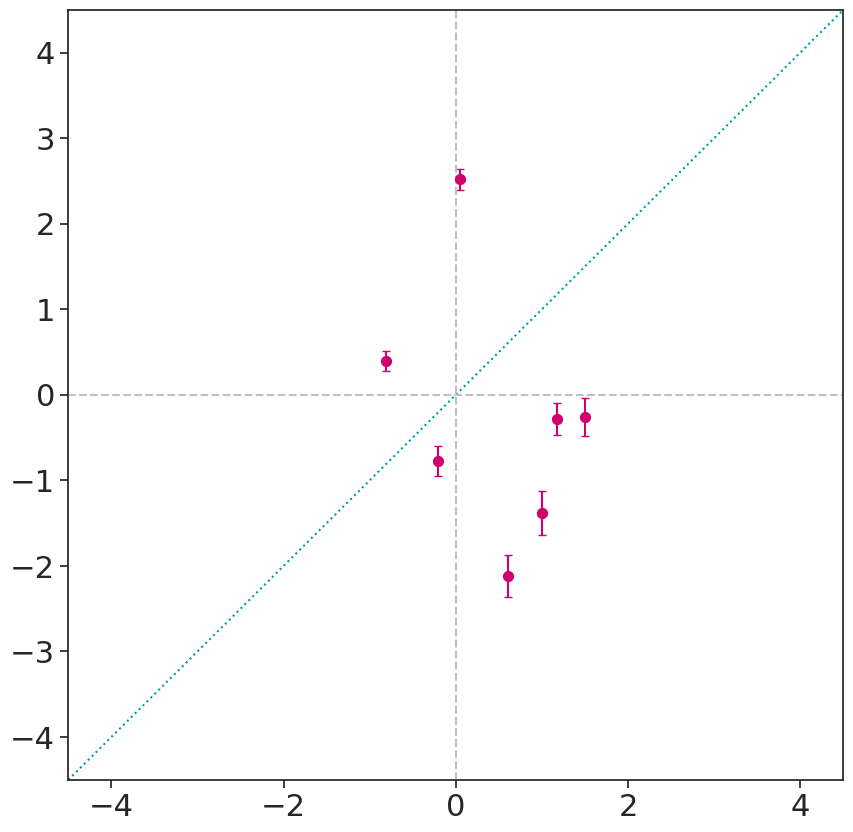

In [92]:
plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
plt.scatter(experimental_free_energies, free_energy_differences, s=50, color="#D0006F")
# plt.scatter(3, 2.5, s=0)

(_, caps, _) = plt.errorbar(experimental_free_energies,
                           free_energy_differences,
                           color="#D0006F",
                           yerr=free_energy_errors,
                           capsize=3,
                           linestyle="",
                           zorder=-1)

plt.plot([-4.5, 4.5], [-4.5, 4.5], color="#0099AB", linestyle=":", zorder=-1)
plt.vlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
plt.hlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
plt.xlim(-4.5, 4.5)
plt.ylim(-4.5, 4.5)


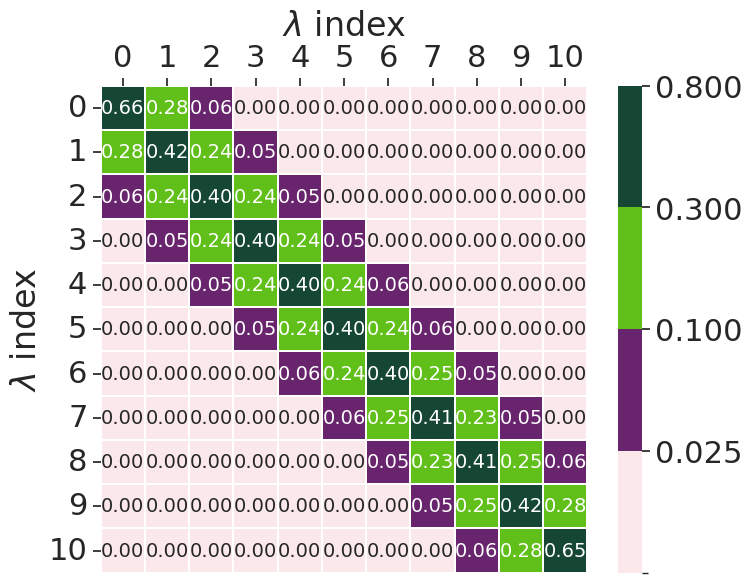

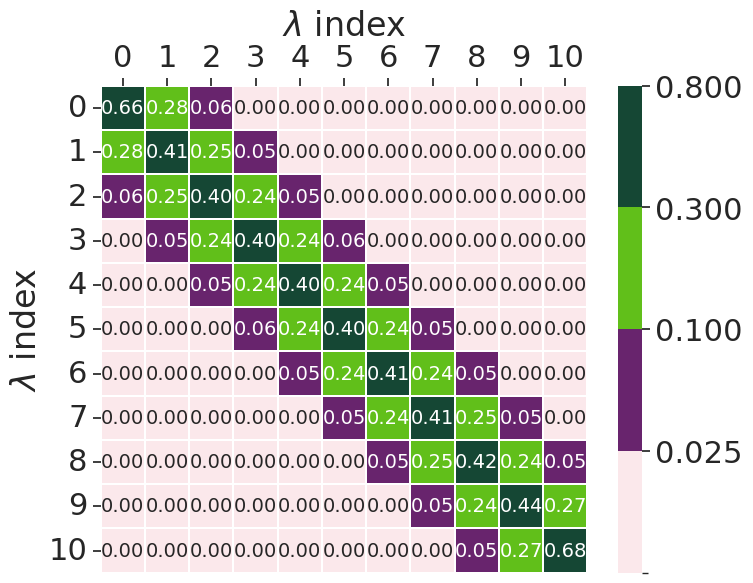

In [94]:
# ligands_all = np.arange(2, 17, 1)
# ligands = np.delete(ligands_all, [10, 12, 13])
stages = ["bound", "unbound"]
# for ligand in ligands:
for stage in stages:
    mbar_file = f"../kpc2/outputs/SOMD/lig_11~lig_5/{stage}/mbar.txt"
    start_index = 1
    end_index = -1
    matrix_lines = []
    with open(mbar_file) as file:
        lines = file.readlines()
        for i in range(len(lines)):
            if "#Overlap matrix" in lines[i]:
                start_index = i + 1
            elif "#DG from neighbouring lambda in kcal/mol" in lines[i]:
                end_index = i
        matrix_lines = lines[start_index:end_index]
    
    matrix = []
    for line in matrix_lines:
        split_line = line.replace("\n", "").split(" ")
        new_line = [float(x) for x in split_line]
        matrix.append(new_line)
    
    colour_map = matplotlib.colors.ListedColormap(['#FBE8EB','#68246D','#61BF1A', '#154734'])
    n_colours = colour_map.N
    boundary_values = [0.0, 0.025, 0.1, 0.3, 0.8]
    norm_colours = matplotlib.colors.BoundaryNorm(boundary_values, n_colours, clip=False)
    colour_bar_args = dict(ticks=[0.025, 0.1, 0.3, 0.8],
                        shrink=0.685)

    fig = plt.figure(figsize=(8, 8))
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=2)
    ax = sns.heatmap(matrix, 
                    annot=True, 
                    fmt=".2f", 
                    linewidths=0.3, 
                    annot_kws={"size": 14}, 
                    square=True, 
                    robust=True, 
                    cmap=colour_map,
                    norm=norm_colours, 
                    cbar_kws=colour_bar_args,
                    vmax=1
                    )
    ax.xaxis.tick_top()
    ax.tick_params(axis="y", rotation=360)
    ax.set_title(r"$\lambda$ index", fontsize=24)
    ax.set_ylabel(r"$\lambda$ index", fontsize=24)
    # ax.set_xlabel(f"{stage} ligand {ligand}", fontsize=24)
    fig.tight_layout()

In [23]:
pearson_r = scipy.stats.pearsonr(experimental_free_energies, free_energy_differences)
pearson_r

PearsonRResult(statistic=-0.7282818140814391, pvalue=0.16291716655872157)

# No minimisation

In [124]:
analysis_file = "../starmap/afe/somd_results_analysis_no_min.txt"

somd_path = "/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/"
paths = sorted(glob.glob(somd_path + "*/"))

for path in paths:
    print(path)
with open(analysis_file, "w") as file:
    for path in paths:
        ligand = path.split("/")[-2]
        free_directory = somd_path + ligand + "/unbound/"
        bound_directory = somd_path + ligand + "/bound/"

        print(ligand)
        transformation = path.split("/")[-2]
        file.write(transformation+"\n")
        free_directory = path + "unbound/"
        bound_directory = path + "bound/"
        try:
            pmf_free, overlap_matrix_free = bss.FreeEnergy.Relative.analyse(free_directory)
            pmf_bound, overlap_matrix_bound = bss.FreeEnergy.Relative.analyse(bound_directory)    
            free_energy_difference, free_energy_error = bss.FreeEnergy.Relative.difference(pmf_bound, pmf_free)
            file.write(f"{free_energy_difference} \u00B1 {free_energy_error} \n")    
        except IndexError as e:
            print(str(e)+"\n")
        except ValueError as e:
            print(str(e)+"\n")
        except BioSimSpace._Exceptions.AnalysisError as e:
            print(str(e))

/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_10/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_11/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_12/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_13/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_14/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_15/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_16/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_2/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_3/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_4/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_5/
/home/jguven/projects/metalloenzymes/starmap/outputs/no_min/SOMD_1/lig_1~lig_6/
/home/jguven/projects/metalloenzy